# Root Cause Analysis
Goal: explain why there is an almost instsant transition between two events

Approach:
1. identify all events with a temporal difference smaller then X

## Investigate candidate events

- Which events?
- In how many cases is this the case?

In [1]:
import sys
sys.path.insert(1, '../')

In [2]:
# own code
from src.io import DOM_DEC, INT_DEC, PER, read_log, to_dataframe                 
from src.insights import *
from src.rca import *
from src.util import stem

# util
from matplotlib import pyplot as plot
from datetime import datetime, timedelta

# Sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

# Visualization
import pydotplus
from IPython.display import SVG
from graphviz import Source

### Domestic Declarations

In [3]:
log_dom_dec = read_log(INT_DEC)

parsing log, completed traces :: 100%|██████████| 6323/6323 [00:12<00:00, 515.36it/s]


In [4]:
features = flat_log(log_dom_dec, 2)
features

,pre,post,pre_ts,post_ts,ts_delta,pre_role,post_role
0,Start trip,End trip,2017-01-09 00:00:00+01:00,2017-01-11 00:00:00+01:00,2 days 00:00:00,EMPLOYEE,EMPLOYEE
1,End trip,Permit SUBMITTED by EMPLOYEE,2017-01-11 00:00:00+01:00,2017-01-23 12:12:42+01:00,12 days 12:12:42,EMPLOYEE,EMPLOYEE
2,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by PRE_APPROVER,2017-01-23 12:12:42+01:00,2017-01-23 12:12:45+01:00,0 days 00:00:03,EMPLOYEE,PRE_APPROVER
3,Permit APPROVED by PRE_APPROVER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-23 12:12:45+01:00,2017-01-23 12:19:11+01:00,0 days 00:06:26,PRE_APPROVER,SUPERVISOR
4,Permit FINAL_APPROVED by SUPERVISOR,Declaration SUBMITTED by EMPLOYEE,2017-01-23 12:19:11+01:00,2017-01-28 18:21:04+01:00,5 days 06:01:53,SUPERVISOR,EMPLOYEE
...,...,...,...,...,...,...,...
64399,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,2018-12-18 12:29:00+01:00,2018-12-18 12:29:03+01:00,0 days 00:00:03,EMPLOYEE,ADMINISTRATION
64400,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,2018-12-18 12:29:03+01:00,2018-12-21 14:04:49+01:00,3 days 01:35:46,ADMINISTRATION,BUDGET OWNER
64401,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,2018-12-21 14:04:49+01:00,2018-12-28 05:15:50+01:00,6 days 15:11:01,BUDGET OWNER,SUPERVISOR
64402,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,2018-12-28 05:15:50+01:00,2019-01-02 10:26:31+01:00,5 days 05:10:41,SUPERVISOR,UNDEFINED


Filter all pair with ts_delta < $\lambda$

In [5]:
lam = timedelta(minutes = 1)

In [6]:
selection = features[features['ts_delta'].apply(lambda x: x < lam)]
print('%s pairs selected.' %len(selection))
selection

9127 pairs selected.


,pre,post,pre_ts,post_ts,ts_delta,pre_role,post_role
2,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by PRE_APPROVER,2017-01-23 12:12:42+01:00,2017-01-23 12:12:45+01:00,00:00:03,EMPLOYEE,PRE_APPROVER
5,Declaration SUBMITTED by EMPLOYEE,Declaration REJECTED by PRE_APPROVER,2017-01-28 18:21:04+01:00,2017-01-28 18:21:13+01:00,00:00:09,EMPLOYEE,PRE_APPROVER
8,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by PRE_APPROVER,2017-02-01 19:55:37+01:00,2017-02-01 19:55:42+01:00,00:00:05,EMPLOYEE,PRE_APPROVER
12,Declaration SUBMITTED by EMPLOYEE,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 08:47:36+01:00,2017-01-09 08:48:00+01:00,00:00:24,EMPLOYEE,SUPERVISOR
17,Permit SUBMITTED by EMPLOYEE,Permit FINAL_APPROVED by SUPERVISOR,2017-01-09 10:28:04+01:00,2017-01-09 10:28:08+01:00,00:00:04,EMPLOYEE,SUPERVISOR
...,...,...,...,...,...,...,...
64384,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,2018-12-05 14:10:17+01:00,2018-12-05 14:10:43+01:00,00:00:26,EMPLOYEE,ADMINISTRATION
64387,Start trip,End trip,2018-12-06 00:00:00+01:00,2018-12-06 00:00:00+01:00,00:00:00,EMPLOYEE,EMPLOYEE
64389,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,2018-12-11 08:02:13+01:00,2018-12-11 08:02:16+01:00,00:00:03,EMPLOYEE,ADMINISTRATION
64393,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,2018-12-09 17:41:05+01:00,2018-12-09 17:41:07+01:00,00:00:02,EMPLOYEE,ADMINISTRATION


Print all pairs, that have a time difference less then $\lambda$.

In [7]:
unique_pre = features['pre'].unique()
unique_post = features['post'].unique()

In [8]:
tuples = []

for events in unique_pre:
    subset = features[features['pre'].apply(lambda name: name is events)]
    
    for idx, row in subset.iterrows():
        tuples.append((row['pre'], row['post']))
        
tuples = list(set(tuples))

In [10]:
for idx, pair in enumerate(tuples):
    print('{:<4d}{:<40s} --> {:<40s}'.format(idx, pair[0], pair[1]))

0   Declaration APPROVED by PRE_APPROVER     --> Declaration FINAL_APPROVED by SUPERVISOR
1   Send Reminder                            --> Send Reminder                           
2   Permit APPROVED by PRE_APPROVER          --> Permit FINAL_APPROVED by SUPERVISOR     
3   Declaration APPROVED by BUDGET OWNER     --> Declaration FINAL_APPROVED by SUPERVISOR
4   Permit APPROVED by BUDGET OWNER          --> Permit FINAL_APPROVED by SUPERVISOR     
5   Permit REJECTED by BUDGET OWNER          --> Permit REJECTED by EMPLOYEE             
6   Permit FINAL_APPROVED by DIRECTOR        --> Start trip                              
7   Permit FINAL_APPROVED by SUPERVISOR      --> Declaration SUBMITTED by EMPLOYEE       
8   Declaration REJECTED by PRE_APPROVER     --> Declaration REJECTED by EMPLOYEE        
9   Permit REJECTED by SUPERVISOR            --> Permit REJECTED by EMPLOYEE             
10  Declaration REJECTED by EMPLOYEE         --> Declaration SUBMITTED by EMPLOYEE       
11  Declar

## Enrich Event Log

1. subselect rows, that contain pairs which are part of the candidates
2. assign response variable
3. classify

### Subselection

In [11]:
sub_features = features[(features['pre'].apply(lambda x: x in unique_pre)) & (features['post'].apply(lambda x: x in unique_post))]
sub_features

,pre,post,pre_ts,post_ts,ts_delta,pre_role,post_role
0,Start trip,End trip,2017-01-09 00:00:00+01:00,2017-01-11 00:00:00+01:00,2 days 00:00:00,EMPLOYEE,EMPLOYEE
1,End trip,Permit SUBMITTED by EMPLOYEE,2017-01-11 00:00:00+01:00,2017-01-23 12:12:42+01:00,12 days 12:12:42,EMPLOYEE,EMPLOYEE
2,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by PRE_APPROVER,2017-01-23 12:12:42+01:00,2017-01-23 12:12:45+01:00,0 days 00:00:03,EMPLOYEE,PRE_APPROVER
3,Permit APPROVED by PRE_APPROVER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-23 12:12:45+01:00,2017-01-23 12:19:11+01:00,0 days 00:06:26,PRE_APPROVER,SUPERVISOR
4,Permit FINAL_APPROVED by SUPERVISOR,Declaration SUBMITTED by EMPLOYEE,2017-01-23 12:19:11+01:00,2017-01-28 18:21:04+01:00,5 days 06:01:53,SUPERVISOR,EMPLOYEE
...,...,...,...,...,...,...,...
64399,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,2018-12-18 12:29:00+01:00,2018-12-18 12:29:03+01:00,0 days 00:00:03,EMPLOYEE,ADMINISTRATION
64400,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,2018-12-18 12:29:03+01:00,2018-12-21 14:04:49+01:00,3 days 01:35:46,ADMINISTRATION,BUDGET OWNER
64401,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,2018-12-21 14:04:49+01:00,2018-12-28 05:15:50+01:00,6 days 15:11:01,BUDGET OWNER,SUPERVISOR
64402,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,2018-12-28 05:15:50+01:00,2019-01-02 10:26:31+01:00,5 days 05:10:41,SUPERVISOR,UNDEFINED


It seems, that all availible activity pairs in the log violate at some point the temporal threshhold.

### Add Response Variable

In [13]:
response = features['ts_delta'].apply(lambda ts: ts <= lam)
sub_features['class'] = response
sub_features

,pre,post,pre_ts,post_ts,ts_delta,pre_role,post_role,class
0,Start trip,End trip,2017-01-09 00:00:00+01:00,2017-01-11 00:00:00+01:00,2 days 00:00:00,EMPLOYEE,EMPLOYEE,False
1,End trip,Permit SUBMITTED by EMPLOYEE,2017-01-11 00:00:00+01:00,2017-01-23 12:12:42+01:00,12 days 12:12:42,EMPLOYEE,EMPLOYEE,False
2,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by PRE_APPROVER,2017-01-23 12:12:42+01:00,2017-01-23 12:12:45+01:00,0 days 00:00:03,EMPLOYEE,PRE_APPROVER,True
3,Permit APPROVED by PRE_APPROVER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-23 12:12:45+01:00,2017-01-23 12:19:11+01:00,0 days 00:06:26,PRE_APPROVER,SUPERVISOR,False
4,Permit FINAL_APPROVED by SUPERVISOR,Declaration SUBMITTED by EMPLOYEE,2017-01-23 12:19:11+01:00,2017-01-28 18:21:04+01:00,5 days 06:01:53,SUPERVISOR,EMPLOYEE,False
...,...,...,...,...,...,...,...,...
64399,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,2018-12-18 12:29:00+01:00,2018-12-18 12:29:03+01:00,0 days 00:00:03,EMPLOYEE,ADMINISTRATION,True
64400,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,2018-12-18 12:29:03+01:00,2018-12-21 14:04:49+01:00,3 days 01:35:46,ADMINISTRATION,BUDGET OWNER,False
64401,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,2018-12-21 14:04:49+01:00,2018-12-28 05:15:50+01:00,6 days 15:11:01,BUDGET OWNER,SUPERVISOR,False
64402,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,2018-12-28 05:15:50+01:00,2019-01-02 10:26:31+01:00,5 days 05:10:41,SUPERVISOR,UNDEFINED,False


Count the number of elements per class:

In [14]:
above = len(sub_features[sub_features['class'] == False]['class'])
below = len(sub_features[sub_features['class'] == True]['class'])
print('above: %s, below: %s, total: %s' %(above, below, above + below))

above: 55261, below: 9143, total: 64404


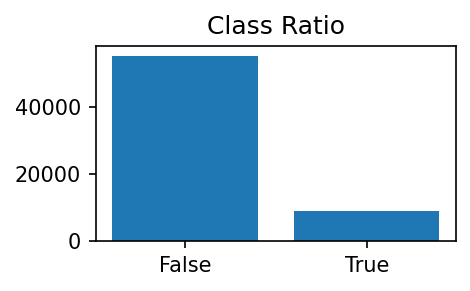

In [15]:
fig = plot.figure(figsize=[2.4, 1.3], dpi=150)
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(['False', 'True'], [above, below])
ax.set_title('Class Ratio')
plot.show()

The classes are highly unbalanced.

### Classification

In [16]:
feature_labels = list(filter(lambda label: label is not 'class', sub_features.columns))
X = feature_labels
Y = sub_features['class']

#### Normalize and One-hot-encode Categorical Features

Build blacklist:

In [17]:
blacklist = ['Declaration', 'by'] + list(sub_features['pre_role'].unique()) + list(sub_features['post_role'].unique())
blacklist = set(blacklist)
blacklist

{'ADMINISTRATION',
 'BUDGET OWNER',
 'DIRECTOR',
 'Declaration',
 'EMPLOYEE',
 'MISSING',
 'PRE_APPROVER',
 'SUPERVISOR',
 'UNDEFINED',
 'by'}

Replace values by normalized labels:

In [18]:
sub_features['pre'] = sub_features['pre'].apply(lambda x: stem(x, blacklist))
sub_features['post'] = sub_features['post'].apply(lambda x: stem(x, blacklist))
# sub_features

In [14]:
sub_features.head()

,pre,post,pre_ts,post_ts,ts_delta,pre_role,post_role,class
0,SUBMITTED,FINAL_APPROVED,2017-01-09 09:49:50+01:00,2017-01-09 11:27:48+01:00,0 days 01:37:58,EMPLOYEE,SUPERVISOR,False
1,FINAL_APPROVED,Request Payment,2017-01-09 11:27:48+01:00,2017-01-10 09:34:44+01:00,0 days 22:06:56,SUPERVISOR,UNDEFINED,False
2,Request Payment,Payment Handled,2017-01-10 09:34:44+01:00,2017-01-12 17:31:22+01:00,2 days 07:56:38,UNDEFINED,UNDEFINED,False
3,SUBMITTED,APPROVED,2017-01-09 10:26:14+01:00,2017-02-22 10:29:21+01:00,44 days 00:03:07,EMPLOYEE,PRE_APPROVER,False
4,APPROVED,FINAL_APPROVED,2017-02-22 10:29:21+01:00,2017-02-23 08:14:45+01:00,0 days 21:45:24,PRE_APPROVER,SUPERVISOR,False


Since sklearn's DecissionTreeClassifier can only handle numeric values, we have to encode all categorical vaules. For that, we use one-hot-encoding:

In [19]:
encoded_features = pd.get_dummies(sub_features[['pre', 'post', 'pre_role', 'post_role']], drop_first=True)
encoded_features.tail()

,pre_APPROVED BUDGET OWNER,pre_End trip,pre_FINAL_APPROVED,pre_Payment Handled,pre_Permit APPROVED,pre_Permit APPROVED BUDGET OWNER,pre_Permit FINAL_APPROVED,pre_Permit REJECTED,pre_Permit REJECTED BUDGET OWNER,pre_Permit SUBMITTED,...,pre_role_PRE_APPROVER,pre_role_SUPERVISOR,pre_role_UNDEFINED,post_role_BUDGET OWNER,post_role_DIRECTOR,post_role_EMPLOYEE,post_role_MISSING,post_role_PRE_APPROVER,post_role_SUPERVISOR,post_role_UNDEFINED
64399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
64401,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
64402,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
64403,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Join encoded features with the numeric features:

In [20]:
pre_ts = sub_features['pre_ts'].apply(lambda ts: ts.timestamp())
post_ts = sub_features['post_ts'].apply(lambda ts: ts.timestamp())

In [21]:
encoded_features = encoded_features.join(pd.DataFrame(pre_ts))
encoded_features = encoded_features.join(pd.DataFrame(post_ts))

Inspect result:

In [22]:
encoded_features.head()

,pre_APPROVED BUDGET OWNER,pre_End trip,pre_FINAL_APPROVED,pre_Payment Handled,pre_Permit APPROVED,pre_Permit APPROVED BUDGET OWNER,pre_Permit FINAL_APPROVED,pre_Permit REJECTED,pre_Permit REJECTED BUDGET OWNER,pre_Permit SUBMITTED,...,pre_role_UNDEFINED,post_role_BUDGET OWNER,post_role_DIRECTOR,post_role_EMPLOYEE,post_role_MISSING,post_role_PRE_APPROVER,post_role_SUPERVISOR,post_role_UNDEFINED,pre_ts,post_ts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.483916e+09,1.484089e+09
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.484089e+09,1.485170e+09
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1.485170e+09,1.485170e+09
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1.485170e+09,1.485170e+09
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1.485170e+09,1.485624e+09


Learn decission tree:

In [23]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(encoded_features, Y)

#### Visualize Decission Tree

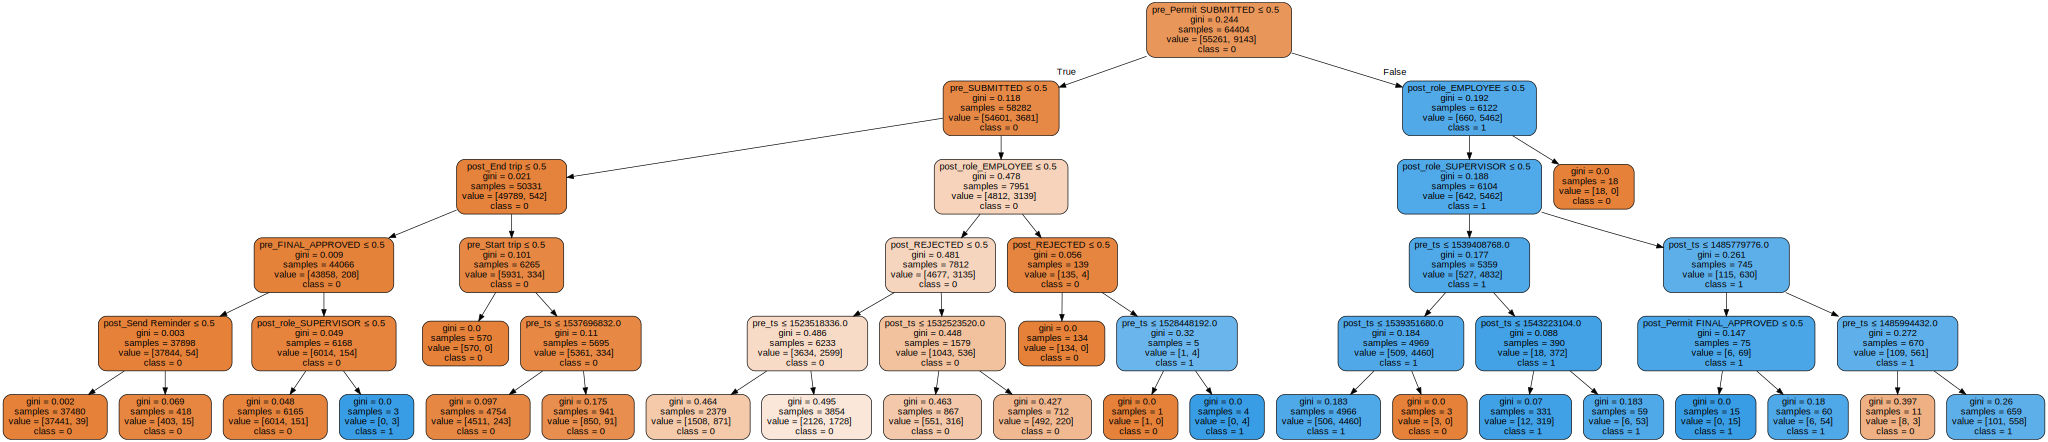

In [25]:
dot_file = open("./figures/decission_tree_root_cause_analysis.dot", 'w')

graph = Source(export_graphviz(clf, out_file=None,  
                filled=True, rounded=True,
                special_characters=True, feature_names = encoded_features.columns, class_names=['0','1']))
SVG(graph.pipe(format='svg'))